In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import os
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.1.0


## 加载数据集

In [10]:
# transform 接受一个图像返回变换后的图像的函数，相当于图像先预处理下
# 常用的操作如 ToTensor, RandomCrop，Normalize等. 
# 他们可以通过transforms.Compose被组合在一起 
transform = transforms.Compose([
     transforms.RandomHorizontalFlip(), # 随机水平翻转
     transforms.RandomGrayscale(), # 图像随机转换为灰度
     transforms.ToTensor(), # # .ToTensor()将shape为(H, W, C)的nump.ndarray或img转为shape为(C, H, W)的tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     #.Normalize作用就是.ToTensor将输入归一化到(0,1)后，再使用公式”(x-mean)/std”，将每个元素分布到(-1,1)

transform1 = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, # 如果true，从training.pt创建数据集
                                        download=True, # 如果ture，从网上自动下载
                                        transform=transform)
# torch.utils.data.DataLoader在训练模型时使用到此函数，用来把训练数据分成多个batch，
# 此函数每次抛出一个batch数据，直至把所有的数据都抛出，train_loader返回一个数据迭代器
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, # 随机打乱数据
                                          ) # kwargs是上面gpu的设置

testset = torchvision.datasets.CIFAR10(root='./data', train=False, # 如果False，从test.pt创建数据集
                                       download=True, transform=transform1)
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False,
                                         )

Files already downloaded and verified
Files already downloaded and verified


In [18]:
trainloader.dataset[0][0].shape

torch.Size([3, 32, 32])

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,64,3,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3,padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(128,128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1,padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv8 = nn.Conv2d(128, 256, 3,padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.fc14 = nn.Linear(512*4*4,1024)
        self.drop1 = nn.Dropout2d()
        self.fc15 = nn.Linear(1024,1024)
        self.drop2 = nn.Dropout2d()
        self.fc16 = nn.Linear(1024,10)


    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)


        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        # print(" x shape ",x.size())
        x = x.view(-1,512*4*4)
        x = F.relu(self.fc14(x))
        x = self.drop1(x)
        x = F.relu(self.fc15(x))
        x = self.drop2(x)
        x = self.fc16(x)

        return x

    def train_sgd(self,device):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)

        path = 'weights.tar'
        initepoch = 0

        if os.path.exists(path) is not True:
            loss = nn.CrossEntropyLoss()
            # optimizer = optim.SGD(self.parameters(),lr=0.01)

        else:
            checkpoint = torch.load(path)
            self.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            initepoch = checkpoint['epoch']
            loss = checkpoint['loss']




        for epoch in range(initepoch,100):  # loop over the dataset multiple times
            timestart = time.time()

            running_loss = 0.0
            total = 0
            correct = 0
            for i, data in enumerate(trainloader, 0):
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device),labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self(inputs)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                # print statistics
                running_loss += l.item()
                # print("i ",i)
                if i % 500 == 499:  # print every 500 mini-batches
                    print('[%d, %5d] loss: %.4f' %
                          (epoch, i, running_loss / 500))
                    running_loss = 0.0
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    print('Accuracy of the network on the %d tran images: %.3f %%' % (total,
                            100.0 * correct / total))
                    total = 0
                    correct = 0
                    torch.save({'epoch':epoch,
                                'model_state_dict':net.state_dict(),
                                'optimizer_state_dict':optimizer.state_dict(),
                                'loss':loss
                                },path)

            print('epoch %d cost %3f sec' %(epoch,time.time()-timestart))

        print('Finished Training')

    def test(self,device):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3f %%' % (
                100.0 * correct / total))


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
net.train_sgd(device)
net.test(device)

[0,   499] loss: 1.4200
Accuracy of the network on the 100 tran images: 57.000 %
epoch 0 cost 39.332747 sec
[1,   499] loss: 0.9389
Accuracy of the network on the 100 tran images: 74.000 %
epoch 1 cost 38.856091 sec
[2,   499] loss: 0.7670
Accuracy of the network on the 100 tran images: 75.000 %
epoch 2 cost 38.829908 sec
[3,   499] loss: 0.6667
Accuracy of the network on the 100 tran images: 69.000 %
epoch 3 cost 38.978296 sec
[4,   499] loss: 0.5888
Accuracy of the network on the 100 tran images: 86.000 %
epoch 4 cost 38.865795 sec
[5,   499] loss: 0.5338
Accuracy of the network on the 100 tran images: 81.000 %
epoch 5 cost 39.045928 sec
[6,   499] loss: 0.4889
Accuracy of the network on the 100 tran images: 82.000 %
epoch 6 cost 39.014673 sec
[7,   499] loss: 0.4449
Accuracy of the network on the 100 tran images: 81.000 %
epoch 7 cost 39.060860 sec
[8,   499] loss: 0.4165
Accuracy of the network on the 100 tran images: 84.000 %
epoch 8 cost 38.942786 sec
[9,   499] loss: 0.3752
Accu

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


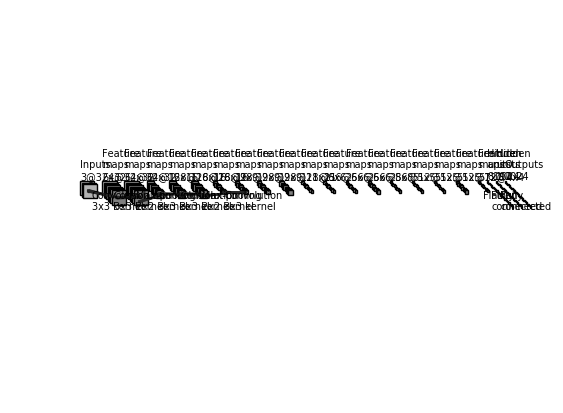

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

NumDots = 4
NumConvMax = 8
NumFcMax = 20
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.


def add_layer(patches, colors, size=(5, 5), num=5,
              top_left=[0, 0],
              loc_diff=[3, -3],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_layer_with_omission(patches, colors, size=(50, 50),
                            num=5, num_max=8,
                            num_dots=4,
                            top_left=[0, 0],
                            loc_diff=[3, -3],
                            ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    this_num = min(num, num_max)
    start_omit = (this_num - num_dots) // 2
    end_omit = this_num - start_omit
    start_omit -= 1
    for ind in range(this_num):
        if (num > num_max) and (start_omit < ind < end_omit):
            omit = True
        else:
            omit = False

        if omit:
            patches.append(
                Circle(loc_start + ind * loc_diff + np.array(size) / 2, 0.5))
        else:
            patches.append(Rectangle(loc_start + ind * loc_diff,
                                     size[1], size[0]))

        if omit:
            colors.append(Black)
        elif ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_mapping(patches, colors, start_ratio, end_ratio, patch_size, ind_bgn,
                top_left_list, loc_diff_list, num_show_list, size_list):

    start_loc = top_left_list[ind_bgn] \
        + (num_show_list[ind_bgn] - 1) * np.array(loc_diff_list[ind_bgn]) \
        + np.array([start_ratio[0] * (size_list[ind_bgn][1] - patch_size[1]),
                    - start_ratio[1] * (size_list[ind_bgn][0] - patch_size[0])]
                   )




    end_loc = top_left_list[ind_bgn + 1] \
        + (num_show_list[ind_bgn + 1] - 1) * np.array(
            loc_diff_list[ind_bgn + 1]) \
        + np.array([end_ratio[0] * size_list[ind_bgn + 1][1],
                    - end_ratio[1] * size_list[ind_bgn + 1][0]])


    patches.append(Rectangle(start_loc, patch_size[1], -patch_size[0]))
    colors.append(Dark)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)



def label(xy, text, xy_off=[0, 4]):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text,
             family='sans-serif', size=7)


if __name__ == '__main__':

    fc_unit_size = 3
    layer_width = 20
    flag_omit = False

    patches = []
    colors = []

    fig, ax = plt.subplots()


    ############################
    # conv layers input      conv1     conv2     pool1     conv3     conv4    pool2   conv5   conv6   conv7     pool3   conv8   conv9   conv10  pool4                  conv13   pool5
    size_list = [(32, 32), (32, 32), (32, 32), (16, 16), (16, 16), (16, 16), (9, 9), (9, 9), (9, 9), (11 ,11), (6, 6), (6, 6), (6, 6), (8, 8), (5, 5), (5, 5), (5, 5), (7, 7), (4, 4)]
    num_list = [3, 64, 64, 64, 128, 128, 128, 128, 128, 128, 128, 256, 256, 256, 256, 512, 512, 512, 512]
    x_diff_list = [0, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30, layer_width + 30]
    text_list = ['Inputs'] + ['Feature\nmaps'] * (len(size_list) - 1)
    loc_diff_list = [[3, -3]] * len(size_list)

    num_show_list = list(map(min, num_list, [NumConvMax] * len(num_list)))
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]

    for ind in range(len(size_list)-1,-1,-1):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumConvMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}@{}x{}'.format(
            num_list[ind], size_list[ind][0], size_list[ind][1]))

    ############################
    # in between layers
    start_ratio_list = [[0.4, 0.5], [0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.5], [0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.5], [0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.5], [0.4, 0.5], [0.4, 0.8]]
    end_ratio_list = [[0.4, 0.5], [0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.5], [0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.5], [0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.5], [0.4, 0.5], [0.4, 0.8]]
    patch_size_list = [(3, 3), (3, 3), (2, 2), (3, 3), (3, 3), (2, 2), (3, 3)]
    ind_bgn_list = range(len(patch_size_list))
    text_list = ['Convolution', 'Convolution', 'Max-pooling', 'Convolution', 'Convolution', 'Max-pooling', 'Convolution', 'Convolution' 'Convolution', 'Max-pooling', 'Convolution', 'Convolution' 'Convolution', 'Max-pooling', 'Convolution', 'Convolution' 'Convolution', 'Max-pooling']

    for ind in range(len(patch_size_list)):
        add_mapping(
            patches, colors, start_ratio_list[ind], end_ratio_list[ind],
            patch_size_list[ind], ind,
            top_left_list, loc_diff_list, num_show_list, size_list)
        label(top_left_list[ind], text_list[ind] + '\n{}x{} kernel'.format(
            patch_size_list[ind][0], patch_size_list[ind][1]), xy_off=[26, -65]
        )


    ############################
    # fully connected layers
    size_list = [(fc_unit_size, fc_unit_size)] * 3
    num_list = [512*4*4, 1024, 1024, 10]
    num_show_list = list(map(min, num_list, [NumFcMax] * len(num_list)))
    x_diff_list = [sum(x_diff_list) + layer_width, layer_width, layer_width]
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]
    loc_diff_list = [[fc_unit_size, -fc_unit_size]] * len(top_left_list)
    text_list = ['Hidden\nunits'] * (len(size_list) - 1) + ['Outputs']

    for ind in range(len(size_list)):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumFcMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind],
                      loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}'.format(
            num_list[ind]))

    text_list = ['Flatten\n', 'Fully\nconnected', 'Fully\nconnected']

    for ind in range(len(size_list)):
        label(top_left_list[ind], text_list[ind], xy_off=[-10, -65])

    ############################
    for patch, color in zip(patches, colors):
        patch.set_color(color * np.ones(3))
        if isinstance(patch, Line2D):
            ax.add_line(patch)
        else:
            patch.set_edgecolor(Black * np.ones(3))
            ax.add_patch(patch)

    plt.tight_layout()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    fig.set_size_inches(8, 2.5)

    fig_dir = './'
    fig_ext = '.png'
    fig.savefig(os.path.join(fig_dir, 'convnet_fig' + fig_ext),
                bbox_inches='tight', pad_inches=0)